In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
%matplotlib inline
from scipy import optimize

from tyssue.core.sheet import Sheet
from tyssue.config.json_parser import load_default 

from tyssue.utils.utils import set_data_columns

import tyssue.geometry.sheet_geometry as geom
import tyssue.dynamics.sheet_vertex_model as model
import tyssue.solvers.sheet_vertex_solver as solver

from tyssue.dynamics.sheet_isotropic_model import isotropic_relax



from tyssue.draw.mpl_draw import sheet_view
import tyssue.draw.mpl_draw as draw
from tyssue.io import hdf5

In [3]:
%pdb

Automatic pdb calling has been turned ON


multiple roots


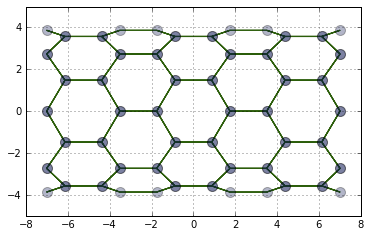

In [12]:
h5store = 'small_hexagonal.hf5'
datasets = hdf5.load_datasets(h5store, data_names=['face', 'jv', 'je'])

sheet = Sheet('emin', datasets)

sheet.set_geom('sheet')
geom.update_all(sheet)

nondim_specs = load_default('dynamics', 'sheet')
dim_model_specs = model.dimentionalize(nondim_specs)

sheet.set_model('sheet', dim_model_specs)
sheet.grad_norm_factor = sheet.settings['grad_norm_factor']
sheet.nrj_norm_factor = sheet.settings['nrj_norm_factor']


isotropic_relax(sheet, nondim_specs)
geom.update_all(sheet)
fig, ax = sheet_view(sheet, ['z', 'x'])

In [13]:
live_je = sheet.upcast_face(sheet.face_df.is_alive).astype(np.bool)
dead_je = np.logical_not(live_je)
inactive_jvs = set(sheet.je_df[dead_je].srce)

active_jvs = set(sheet.jv_df.index).difference(inactive_jvs)
active_jvs = list(active_jvs)
sheet.jv_df.is_active = 0
sheet.jv_df.loc[active_jvs, 'is_active'] = 1

In [14]:
%pdb

Automatic pdb calling has been turned ON


In [15]:
settings = {
    'minimize': {
        'options': {'disp':True,
        'gtol':1e-4},
        'jac': solver.opt_grad
        }
    }



res = solver.find_energy_min(sheet, geom, model, pos_idx=active_jvs, **settings)
print(res['success'])

True


In [8]:
from tyssue.topology.sheet_topology import type1_transition

![Type 1 transition](../../doc/illus/t1_transition.png)

In [9]:
type1_transition(sheet, 84)
geom.update_all(sheet)


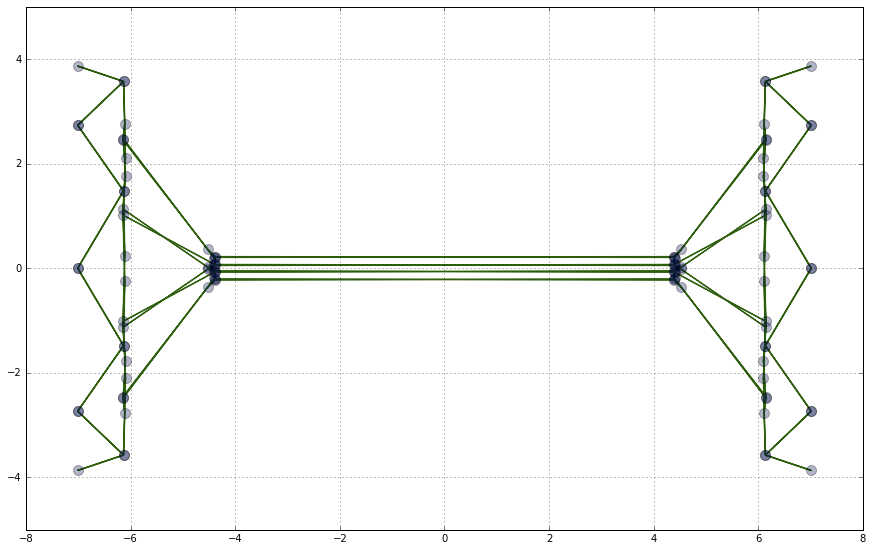

In [16]:

fig, ax = sheet_view(sheet, ['z', 'x'])

#ax.set_xlim(-5, 5)
ax.set_aspect('equal')
fig.set_size_inches(15, 15)


In [9]:
%pdb

Automatic pdb calling has been turned OFF


True


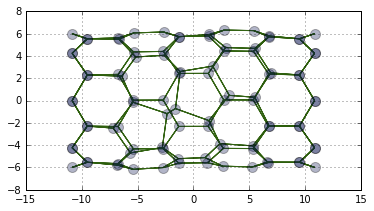

In [15]:
settings = {
    'minimize': {
        'options': {'disp':True,
        'gtol':1e-6},
        'jac': solver.opt_grad
        }
    }


res = solver.find_energy_min(sheet, geom, model, **settings)
print(res['success'])
fig, ax = sheet_view(sheet, ['z', 'x'])

In [17]:
apoptotic_cell = 45

In [30]:
mod_spec, dim_mod_spec = sheet.set_model(model)

In [40]:
dim_mod_spec

{'face': {'contractility': (96.0, float),
  'prefered_area': (24.0, float),
  'prefered_height': (10.0, float),
  'prefered_vol': (240.0, float),
  'vol_elasticity': (1.0, float)},
 'je': {'line_tension': (1410.9060918431107, float)},
 'jv': {'radial_tension': (0.0, float)},
 'settings': {'grad_norm_factor': 11757.550765359256,
  'nrj_norm_factor': 57600.0}}

In [43]:
np.logspace(0, -9, 10, base=2)

array([ 1.        ,  0.5       ,  0.25      ,  0.125     ,  0.0625    ,
        0.03125   ,  0.015625  ,  0.0078125 ,  0.00390625,  0.00195312])

In [39]:
n_steps = 10

pref_vols = np.logspace(0, -9, n_steps, base=2) * dim_mod_spec['face']['prefered_vol'][0]
rad_tension = np.linspace(0, 1, n_steps) * dim_mod_spec['jv']['radial_tension'][0]

In [35]:
'test_apopto_{:.3f}.png'.format(pref_vols[0])

'test_apopto_240.000.png'

In [36]:
for pref_v in pref_vols:
    sheet.face_df.loc[apoptotic_cell, 'prefered_vol'] = pref_v
    res = solver.find_energy_min(sheet, geom, model, **settings)
    fig, ax = sheet_view(sheet, ['z', 'x'])
    plt.savefig('test_apopto_{:.3f}.png'.format(pref_v))
    plt.close()

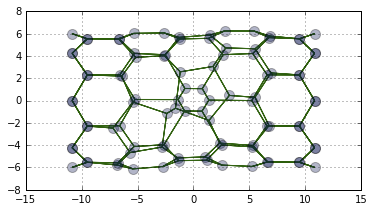

In [37]:
fig, ax = sheet_view(sheet, ['z', 'x'])